In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torch.nn.functional as F

from torch.autograd import Variable
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

from tkmodel.TwoCUM_copy import TwoCUMfittingConc
from tkmodel.TwoCUM_copy import TwoCUM

In [2]:
from ml_model.data_generation import uterus


In [3]:
num = 100000
    
uterus_data = uterus(num)

In [4]:
y = uterus_data.y

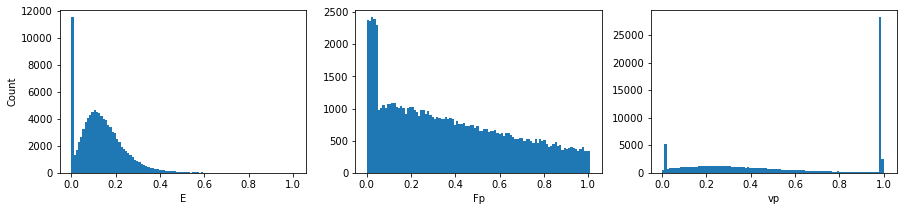

<Figure size 432x288 with 0 Axes>

In [21]:


E = y[:,0]
Fp = y[:,1]
vp = y[:,2]

fig, axs = plt.subplots(1, 3, figsize=(15, 3))

axs[0].hist(E,range=[0, 1.01], bins = 100)
axs[0].set_xlabel('E')
axs[0].set_ylabel('Count')


axs[1].hist(100*Fp,range=[0, 1.01], bins = 100)
axs[1].set_xlabel('Fp')


axs[2].hist(vp,range=[0, 1.01], bins = 100)
axs[2].set_xlabel('vp')


plt.show()
plt.clf()

In [15]:
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme", "halfnorm"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [16]:
real_x = uterus_data.real_x
real_y = uterus_data.real_y
real_x.shape, real_y.shape

((42599, 150), (42599, 3))

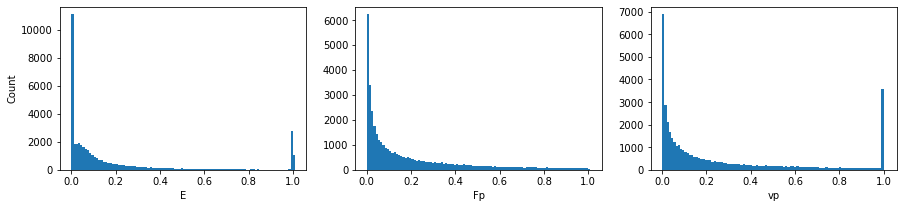

<Figure size 432x288 with 0 Axes>

In [18]:


E = real_y[:,0]
Fp = real_y[:,1]
vp = real_y[:,2]

fig, axs = plt.subplots(1, 3, figsize=(15, 3))

axs[0].hist(E,range=[0, 1.01], bins = 100)
axs[0].set_xlabel('E')
axs[0].set_ylabel('Count')


axs[1].hist(100*Fp,range=[0, 1.01], bins = 100)
axs[1].set_xlabel('Fp')


axs[2].hist(vp,range=[0, 1.01], bins = 100)
axs[2].set_xlabel('vp')


plt.show()
plt.clf()

# Find new dist for E

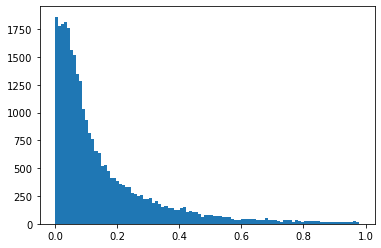

In [37]:
E_list = real_y[:,0]
E_restricted = E_list[(E_list > 0.00001) & (E_list < 0.98)]

plt.hist(E_restricted, bins = 100)
plt.show()

In [38]:


best_dist, best_p, params = get_best_distribution(E_restricted)

p value for norm = 0.0
p value for exponweib = 2.282239779129942e-12
p value for weibull_max = 0.0
p value for weibull_min = 1.3137373629612729e-38
p value for pareto = 6.553737875277351e-19
p value for genextreme = 2.1278022003165033e-30
p value for halfnorm = 0.0
Best fitting distribution: exponweib
Best p value: 2.282239779129942e-12
Parameters for the best fit: (1.7162775627078726, 0.6992052384902265, 7.607697024682173e-06, 0.08199239222931205)


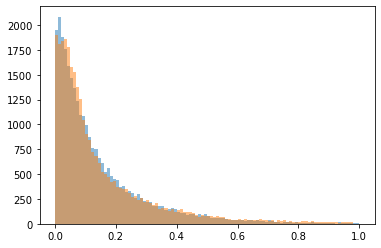

In [40]:
params = (1.7162775627078726, 0.6992052384902265, 7.607697024682173e-06, 0.08199239222931205)
dist_num = E_restricted.shape[0]
gen_data_E = st.exponweib.rvs(params[0], params[1], params[2], params[3], size=dist_num)

plt.hist(gen_data_E, bins = 100, range=[0, 1], alpha = 0.5)
plt.hist(E_restricted, bins = 100, range=[0, 1], alpha = 0.5)

plt.show()

In [48]:
#find percentage values at the edges
size = E_list.shape[0]

start = E_list[(E_list < 0.00001)]
end = E_list[(E_list > 0.98)]

start_percent = start.shape[0]/size
end_percent = end.shape[0]/size

start_percent, end_percent

(0.21577971313880606, 0.09157491959905162)

In [53]:
def E_distribution(num):
    start_percent, end_percent = 0.2157, 0.0915
    params = (1.7162775627078726, 0.6992052384902265, 7.607697024682173e-06, 0.08199239222931205)
    start_nums = int(start_percent*num)
    end_nums = int(end_percent*num)
    
    start = np.random.uniform(low = 0, high= 0.00001, size = start_nums)
    end = np.random.uniform(low = 0.98, high= 1, size = end_nums)
    
    dist_num = num - start_nums - end_nums
    gen_data_E = st.exponweib.rvs(params[0], params[1], params[2], params[3], size=dist_num)
    gen_data_E = np.array(gen_data_E)
    
    true_dist = np.concatenate((start, gen_data_E), axis=None)
    true_dist = np.concatenate((true_dist, end), axis=None)

    return true_dist

(42599,) (42599,)


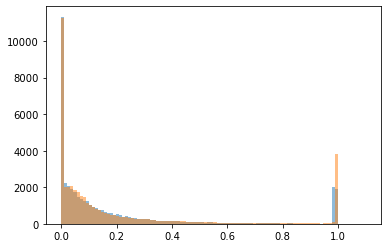

In [54]:
gen_data_E = E_distribution(E_list.shape[0])
print(gen_data_E.shape, E_list.shape)

plt.hist(gen_data_E, bins = 100, range=[0, 1.1], alpha = 0.5)
plt.hist(E_list, bins = 100, range=[0, 1.1], alpha = 0.5)

plt.show()